### 1. Classification
#### Banking Dataset - Marketing Targets

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix, f1_score, precision_score
from sklearn.inspection import plot_partial_dependence

import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost
from xgboost import XGBClassifier, XGBRegressor
from xgboost import plot_importance
from catboost import CatBoostClassifier, Pool, metrics, cv
from lightgbm import plot_importance
from lightgbm import LGBMClassifier

In [57]:
bank = pd.read_csv('banking.csv', sep=";")
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [58]:
bank.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [59]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [60]:
bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

- Target variable distribution

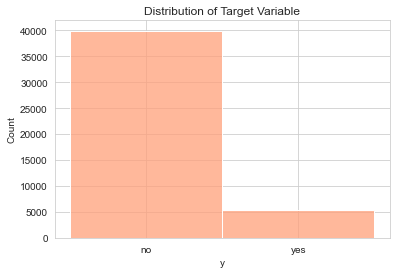

In [61]:
sns.histplot(bank['y'], color="lightsalmon")
plt.title("Distribution of Target Variable");

In [62]:
bank['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

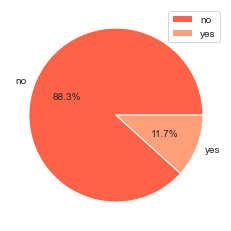

In [63]:
temp = list(bank['y'].value_counts())
categories=['no', 'yes']
plt.pie(temp, labels=categories, autopct='%0.1f%%', colors=['tomato', 'lightsalmon'])
plt.legend(categories);

- Predictor variables distribution

In [64]:
bank.shape

(45211, 17)

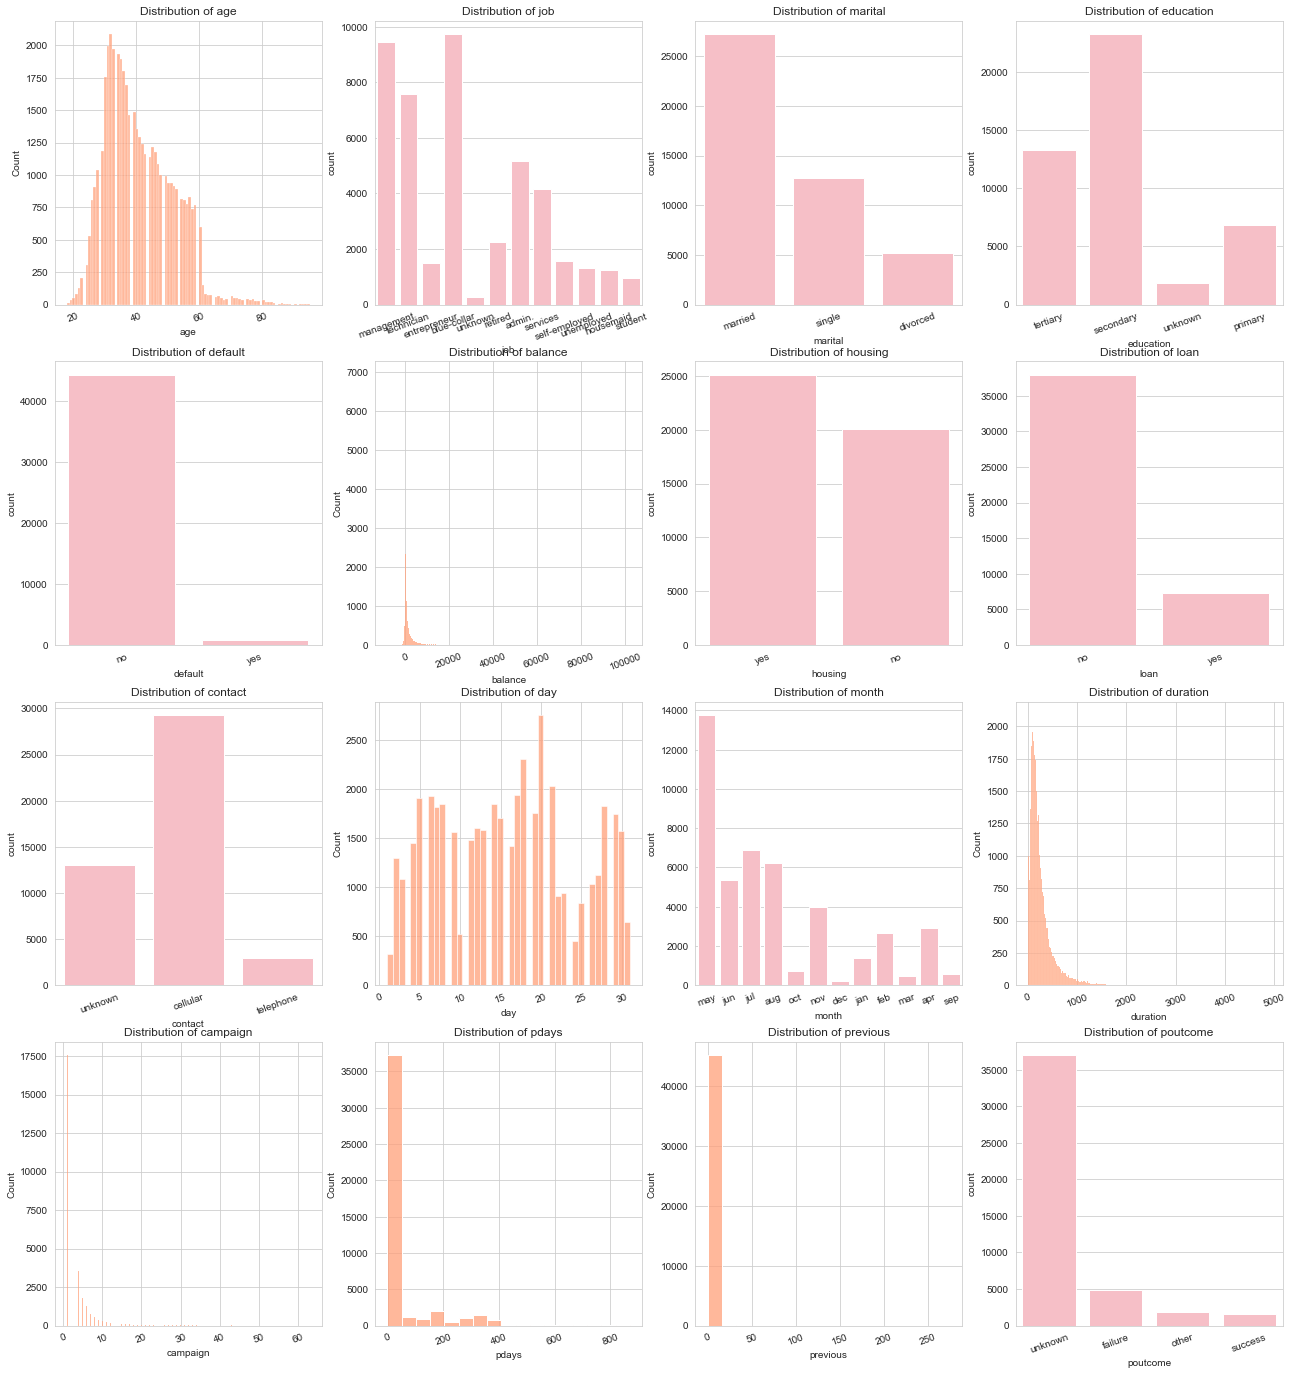

In [65]:
intcols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays','previous']
fig = plt.figure(figsize=(22, 24))
for i in range(bank.shape[1]-1):
    plt.subplot(4, 4, i+1)
    if bank.columns[i] in intcols:
        sns.histplot(bank[bank.columns[i]], color="lightsalmon")
    else:
        sns.countplot(bank[bank.columns[i]], color="lightpink")
    plt.xticks(rotation=20)
    plt.title("Distribution of "+bank.columns[i]);

- Predictor vs target variable

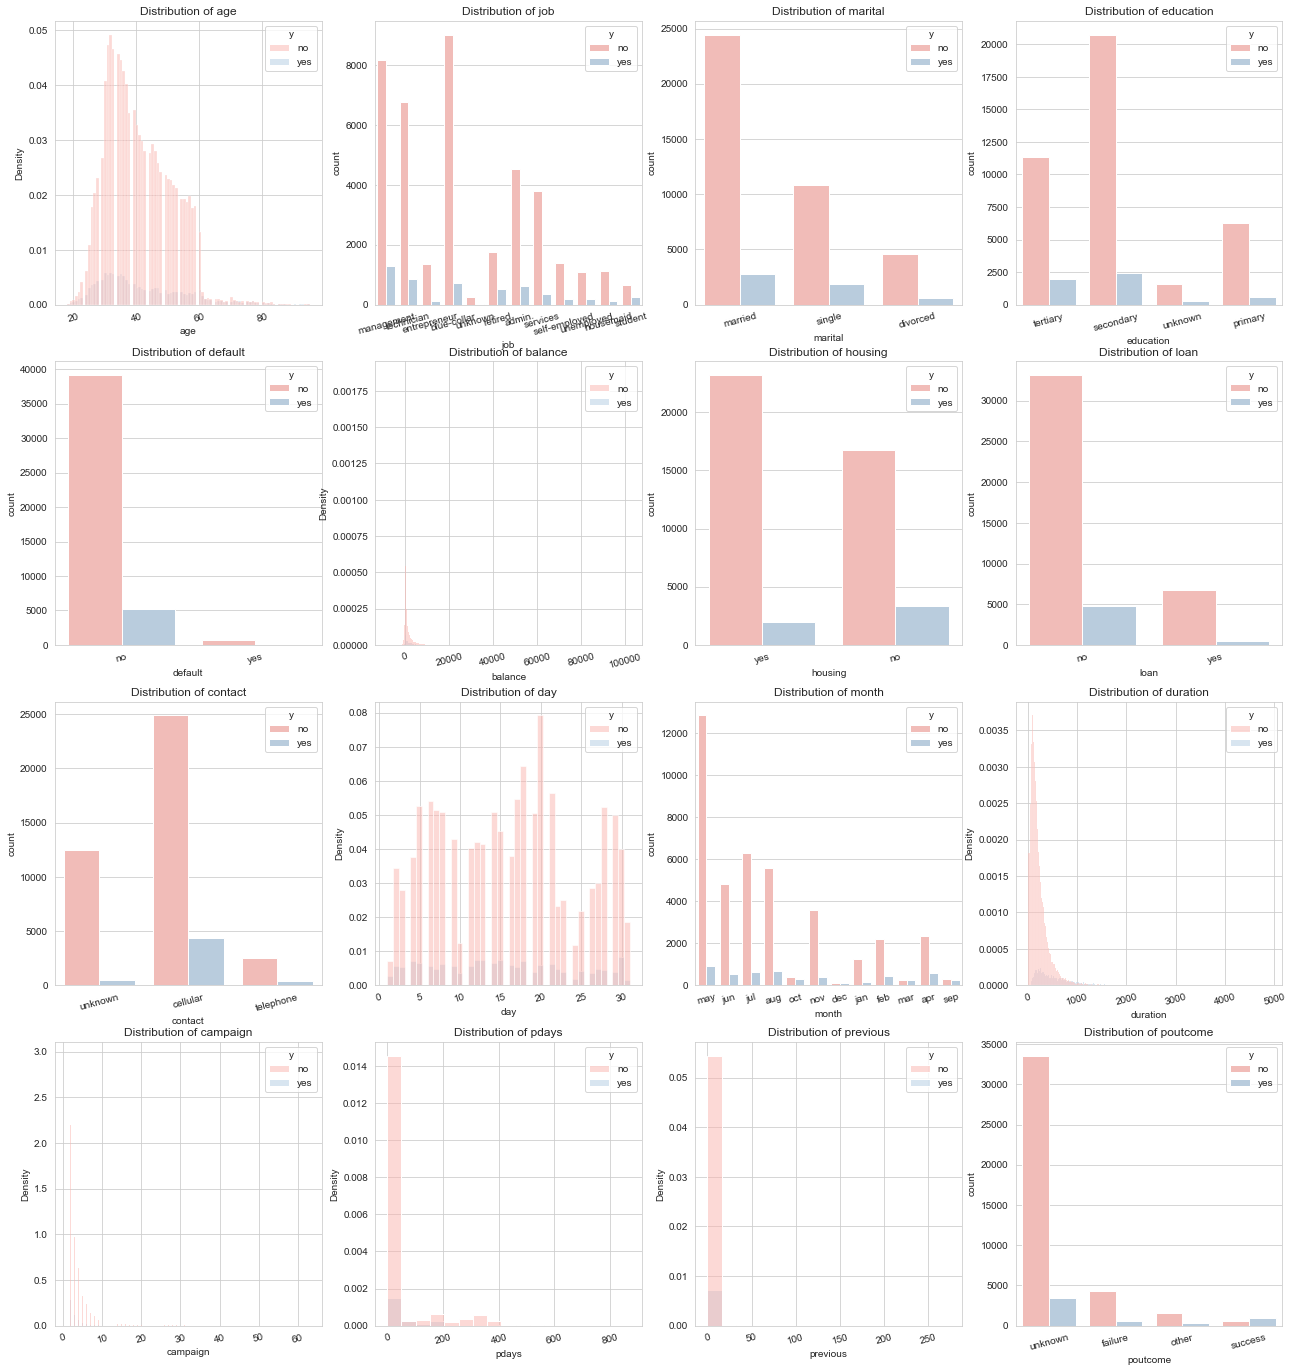

In [66]:
fig = plt.figure(figsize=(22, 24))
for i in range(bank.shape[1]-1):
    plt.subplot(4, 4, i+1)
    if bank.columns[i] in intcols:
        sns.histplot(x=bank.columns[i], data=bank, hue="y", stat="density", palette="Pastel1")
    else:
        sns.countplot(x=bank.columns[i], data=bank, hue="y", palette="Pastel1")
    plt.xticks(rotation=15)
    plt.title("Distribution of "+bank.columns[i]);

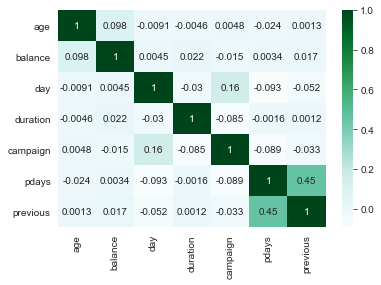

In [67]:
cor = bank.corr()
sns.heatmap(cor, annot = True, color = 'blue',  cmap="BuGn");

day 변수의 경우 수치형 변수로 사용하기에는 날짜의 숫자가 증가하는 것이 값이 커지는 것을 의미하지 않고, 범주형 변수로 사용하기에는 범주가 많으므로 분석에서 제외한다.

In [68]:
bank = bank.drop('day', axis=1)
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,may,198,1,-1,0,unknown,no


#### Modeling
- 카테고리형 변수들에 대해 one hot encoding
- 전체 데이터의 70%는 train, 30%는 test set으로 split

In [69]:
X = bank.drop('y', axis=1)
X1 = pd.get_dummies(X)
y = bank['y']

train_x, test_x, train_y, test_y = train_test_split(X1, y, test_size=0.3, random_state=777)
train_x.head()

,age,balance,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
41161,22,4111,65,1,-1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3123,38,360,220,2,-1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
17925,54,0,250,5,-1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
40638,30,685,299,2,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6676,53,45,171,6,-1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


#### 1) XGBoost

- case 1: 기본 파라미터

In [70]:
start = time.time()
xgb1 = XGBClassifier(random_state=777, eval_metric = 'logloss')
xgb1.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))
pred_xgb1 = xgb1.predict(test_x)
print(xgb1.set_params)

실행시간:1.4866752624511719
<bound method XGBModel.set_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=777,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>


In [71]:
con_mat1 = confusion_matrix(test_y, pred_xgb1)
con_mat1

array([[11544,   474],
       [  839,   707]], dtype=int64)

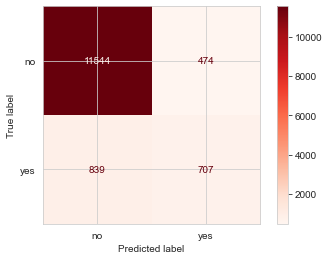

In [72]:
plot_confusion_matrix(xgb1, test_x, test_y, cmap = plt.cm.Reds);

In [75]:
print("Accuracy: {}".format(accuracy_score(test_y, pred_xgb1)))
print(classification_report(test_y, pred_xgb1))

Accuracy: 0.9031996461220879
              precision    recall  f1-score   support

          no       0.93      0.96      0.95     12018
         yes       0.60      0.46      0.52      1546

    accuracy                           0.90     13564
   macro avg       0.77      0.71      0.73     13564
weighted avg       0.89      0.90      0.90     13564



- case 2: learning rate를 작게, 트리 생성 횟수는 크게 설정

In [76]:
start = time.time()
xgb2 = XGBClassifier(n_estimators = 1000, learning_rate=0.01, 
                     eval_metric='logloss', random_state=777)
xgb2.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))
pred_xgb2 = xgb2.predict(test_x)

실행시간:14.789944887161255


[[11588   430]
 [  864   682]]


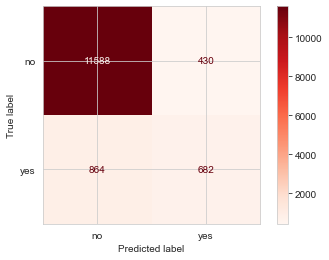

In [77]:
con_mat2 = confusion_matrix(test_y, pred_xgb2)
print(con_mat2)
plot_confusion_matrix(xgb2, test_x, test_y, cmap = plt.cm.Reds);

In [78]:
print("Accuracy: {}".format(accuracy_score(test_y, pred_xgb2)))
print(classification_report(test_y, pred_xgb2))

Accuracy: 0.9046004128575641
              precision    recall  f1-score   support

          no       0.93      0.96      0.95     12018
         yes       0.61      0.44      0.51      1546

    accuracy                           0.90     13564
   macro avg       0.77      0.70      0.73     13564
weighted avg       0.89      0.90      0.90     13564



- case 3: Randomizedsesarch를 통한 최적화

In [80]:
start = time.time()
xgb3 = XGBClassifier(eval_metric='logloss')
xgb_grid = {
    'max_depth':[4, 5, 6],
    'colsample_bytree':[0.6,0.8],
    'gamma': [0.5, 0.75, 1],
    'n_estimators':[700, 1000],
    'learning_rate':[0.01, 0.05, 0.1],
    'random_state':[777]
}
xgbCV = GridSearchCV(xgb3, xgb_grid, verbose=2,cv=3)
xgbCV.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=4, n_estimators=700, random_state=777; total time=   4.0s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=4, n_estimators=700, random_state=777; total time=   4.0s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=4, n_estimators=700, random_state=777; total time=   4.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=4, n_estimators=1000, random_state=777; total time=   6.0s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=4, n_estimators=1000, random_state=777; total time=   6.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=4, n_estimators=1000, random_state=777; total time=   6.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.01, max_depth=5, n_estimators=700, random_state=777; total time=   5.5s
[CV] END colsample_bytre

[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=5, n_estimators=1000, random_state=777; total time=   7.7s
[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=5, n_estimators=1000, random_state=777; total time=   7.4s
[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=5, n_estimators=1000, random_state=777; total time=   7.7s
[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=6, n_estimators=700, random_state=777; total time=   6.5s
[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=6, n_estimators=700, random_state=777; total time=   6.6s
[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=6, n_estimators=700, random_state=777; total time=   6.3s
[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=6, n_estimators=1000, random_state=777; total time=   8.8s
[CV] END colsample_bytree=0.6, gamma=0.75, learning_rate=0.01, max_depth=6, n_e

[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=4, n_estimators=700, random_state=777; total time=   4.1s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=4, n_estimators=700, random_state=777; total time=   3.9s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=4, n_estimators=700, random_state=777; total time=   3.8s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=4, n_estimators=1000, random_state=777; total time=   5.3s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=4, n_estimators=1000, random_state=777; total time=   5.4s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=4, n_estimators=1000, random_state=777; total time=   5.4s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=700, random_state=777; total time=   4.8s
[CV] END colsample_bytree=0.6, gamma=1, learning_rate=0.05, max_depth=5, n_estimators=700, random_sta

[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=1000, random_state=777; total time=  13.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=5, n_estimators=1000, random_state=777; total time=  12.5s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=700, random_state=777; total time=  10.8s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=700, random_state=777; total time=  10.9s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=700, random_state=777; total time=  11.1s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=1000, random_state=777; total time=  15.3s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimators=1000, random_state=777; total time=  14.9s
[CV] END colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=6, n_estimator

[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=4, n_estimators=700, random_state=777; total time=   7.1s
[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=4, n_estimators=700, random_state=777; total time=   7.1s
[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=4, n_estimators=1000, random_state=777; total time=  10.3s
[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=4, n_estimators=1000, random_state=777; total time=  10.3s
[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=4, n_estimators=1000, random_state=777; total time=  10.1s
[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=5, n_estimators=700, random_state=777; total time=   8.8s
[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=5, n_estimators=700, random_state=777; total time=   8.7s
[CV] END colsample_bytree=0.8, gamma=0.75, learning_rate=0.1, max_depth=5, n_estimators

[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=5, n_estimators=1000, random_state=777; total time=  12.5s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=700, random_state=777; total time=  10.2s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=700, random_state=777; total time=  10.5s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=700, random_state=777; total time=  11.1s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=1000, random_state=777; total time=  15.0s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=1000, random_state=777; total time=  15.3s
[CV] END colsample_bytree=0.8, gamma=1, learning_rate=0.1, max_depth=6, n_estimators=1000, random_state=777; total time=  15.4s
실행시간:2814.743095636368


In [81]:
print(xgbCV.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.75, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 700, 'random_state': 777}


In [82]:
start = time.time()
xgb3 = XGBClassifier(colsample_bytree=0.6, gamma=0.75, max_depth=4,
                     n_estimators = 700, learning_rate=0.05, 
                     eval_metric='logloss', random_state=777)
xgb3.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))
pred_xgb3 = xgb3.predict(test_x)

실행시간:9.281261205673218


In [83]:
con_mat3 = confusion_matrix(test_y, pred_xgb3)
con_mat3

array([[11590,   428],
       [  856,   690]], dtype=int64)

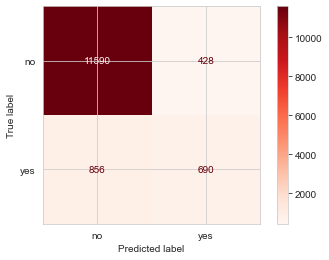

In [84]:
plot_confusion_matrix(xgb3, test_x, test_y, cmap = plt.cm.Reds);

In [85]:
print("Accuracy: {}".format(accuracy_score(test_y, pred_xgb3)))
print(classification_report(test_y, pred_xgb3))

Accuracy: 0.9053376585078148
              precision    recall  f1-score   support

          no       0.93      0.96      0.95     12018
         yes       0.62      0.45      0.52      1546

    accuracy                           0.91     13564
   macro avg       0.77      0.71      0.73     13564
weighted avg       0.90      0.91      0.90     13564



#### 2) CatBoost

In [88]:
catcols = list(set(bank.columns[:-1]) - set(intcols))
for c in catcols:
    X[c] = X[c].astype('category')
    
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=777)
train_x.head()

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome
41161,22,admin.,single,secondary,no,4111,no,yes,cellular,aug,65,1,-1,0,unknown
3123,38,blue-collar,married,secondary,no,360,yes,no,unknown,may,220,2,-1,0,unknown
17925,54,entrepreneur,married,tertiary,no,0,no,no,cellular,jul,250,5,-1,0,unknown
40638,30,management,single,tertiary,no,685,no,no,cellular,aug,299,2,-1,0,unknown
6676,53,technician,divorced,secondary,no,45,no,no,unknown,may,171,6,-1,0,unknown


- case 1: 기본 파라미터

In [89]:
start = time.time()
cat1 = CatBoostClassifier(
    boosting_type="Plain",
    random_state=777, 
    loss_function='Logloss'
)


cat1.fit(train_x, train_y,
        verbose=True,
        cat_features = catcols 
)

print("실행시간:{}".format(time.time()-start))
pred_cat1 = cat1.predict(test_x)

Learning rate set to 0.045038
0:	learn: 0.6401807	total: 257ms	remaining: 4m 16s
1:	learn: 0.5917973	total: 346ms	remaining: 2m 52s
2:	learn: 0.5489930	total: 468ms	remaining: 2m 35s
3:	learn: 0.5120869	total: 559ms	remaining: 2m 19s
4:	learn: 0.4867676	total: 616ms	remaining: 2m 2s
5:	learn: 0.4622143	total: 656ms	remaining: 1m 48s
6:	learn: 0.4395948	total: 740ms	remaining: 1m 44s
7:	learn: 0.4180997	total: 799ms	remaining: 1m 39s
8:	learn: 0.4033958	total: 842ms	remaining: 1m 32s
9:	learn: 0.3842186	total: 906ms	remaining: 1m 29s
10:	learn: 0.3691906	total: 975ms	remaining: 1m 27s
11:	learn: 0.3531067	total: 1.05s	remaining: 1m 26s
12:	learn: 0.3409238	total: 1.11s	remaining: 1m 24s
13:	learn: 0.3336713	total: 1.14s	remaining: 1m 20s
14:	learn: 0.3226196	total: 1.21s	remaining: 1m 19s
15:	learn: 0.3162084	total: 1.27s	remaining: 1m 18s
16:	learn: 0.3073892	total: 1.33s	remaining: 1m 17s
17:	learn: 0.3008250	total: 1.37s	remaining: 1m 14s
18:	learn: 0.2926475	total: 1.43s	remaining: 

159:	learn: 0.2004527	total: 11.6s	remaining: 1m 1s
160:	learn: 0.2004036	total: 11.7s	remaining: 1m 1s
161:	learn: 0.2003769	total: 11.8s	remaining: 1m 1s
162:	learn: 0.2003528	total: 11.9s	remaining: 1m 1s
163:	learn: 0.2003422	total: 11.9s	remaining: 1m
164:	learn: 0.2002843	total: 12s	remaining: 1m
165:	learn: 0.2001185	total: 12.1s	remaining: 1m
166:	learn: 0.2001134	total: 12.1s	remaining: 1m
167:	learn: 0.2000692	total: 12.2s	remaining: 1m
168:	learn: 0.1999510	total: 12.3s	remaining: 1m
169:	learn: 0.1998759	total: 12.4s	remaining: 1m
170:	learn: 0.1997821	total: 12.4s	remaining: 1m
171:	learn: 0.1995851	total: 12.5s	remaining: 1m
172:	learn: 0.1993459	total: 12.6s	remaining: 1m
173:	learn: 0.1992790	total: 12.7s	remaining: 1m
174:	learn: 0.1991966	total: 12.7s	remaining: 1m
175:	learn: 0.1990841	total: 12.8s	remaining: 1m
176:	learn: 0.1990572	total: 12.9s	remaining: 60s
177:	learn: 0.1989260	total: 13s	remaining: 1m
178:	learn: 0.1988862	total: 13.1s	remaining: 1m
179:	learn:

320:	learn: 0.1896796	total: 24s	remaining: 50.7s
321:	learn: 0.1895880	total: 24s	remaining: 50.6s
322:	learn: 0.1894784	total: 24.1s	remaining: 50.5s
323:	learn: 0.1894214	total: 24.2s	remaining: 50.5s
324:	learn: 0.1893957	total: 24.3s	remaining: 50.4s
325:	learn: 0.1893057	total: 24.3s	remaining: 50.3s
326:	learn: 0.1892785	total: 24.4s	remaining: 50.3s
327:	learn: 0.1891986	total: 24.5s	remaining: 50.2s
328:	learn: 0.1891661	total: 24.6s	remaining: 50.1s
329:	learn: 0.1891464	total: 24.7s	remaining: 50.1s
330:	learn: 0.1890099	total: 24.8s	remaining: 50.1s
331:	learn: 0.1889978	total: 24.8s	remaining: 50s
332:	learn: 0.1889861	total: 24.9s	remaining: 49.9s
333:	learn: 0.1889026	total: 25s	remaining: 49.8s
334:	learn: 0.1888711	total: 25.1s	remaining: 49.7s
335:	learn: 0.1888512	total: 25.2s	remaining: 49.7s
336:	learn: 0.1888392	total: 25.3s	remaining: 49.7s
337:	learn: 0.1888093	total: 25.4s	remaining: 49.7s
338:	learn: 0.1887741	total: 25.4s	remaining: 49.6s
339:	learn: 0.188707

479:	learn: 0.1820259	total: 37.3s	remaining: 40.4s
480:	learn: 0.1820117	total: 37.4s	remaining: 40.4s
481:	learn: 0.1819762	total: 37.5s	remaining: 40.3s
482:	learn: 0.1818570	total: 37.6s	remaining: 40.2s
483:	learn: 0.1818324	total: 37.7s	remaining: 40.1s
484:	learn: 0.1818160	total: 37.7s	remaining: 40.1s
485:	learn: 0.1818104	total: 37.8s	remaining: 40s
486:	learn: 0.1817730	total: 37.9s	remaining: 39.9s
487:	learn: 0.1817131	total: 38s	remaining: 39.8s
488:	learn: 0.1816928	total: 38.1s	remaining: 39.8s
489:	learn: 0.1816375	total: 38.2s	remaining: 39.7s
490:	learn: 0.1816238	total: 38.2s	remaining: 39.6s
491:	learn: 0.1815957	total: 38.3s	remaining: 39.6s
492:	learn: 0.1815681	total: 38.4s	remaining: 39.5s
493:	learn: 0.1815147	total: 38.5s	remaining: 39.4s
494:	learn: 0.1814715	total: 38.6s	remaining: 39.3s
495:	learn: 0.1814110	total: 38.6s	remaining: 39.3s
496:	learn: 0.1813534	total: 38.7s	remaining: 39.2s
497:	learn: 0.1813281	total: 38.8s	remaining: 39.1s
498:	learn: 0.18

639:	learn: 0.1759736	total: 49.9s	remaining: 28.1s
640:	learn: 0.1759188	total: 50s	remaining: 28s
641:	learn: 0.1758688	total: 50s	remaining: 27.9s
642:	learn: 0.1757754	total: 50.1s	remaining: 27.8s
643:	learn: 0.1757176	total: 50.2s	remaining: 27.7s
644:	learn: 0.1756676	total: 50.2s	remaining: 27.6s
645:	learn: 0.1756434	total: 50.3s	remaining: 27.6s
646:	learn: 0.1755847	total: 50.4s	remaining: 27.5s
647:	learn: 0.1755529	total: 50.5s	remaining: 27.4s
648:	learn: 0.1755182	total: 50.5s	remaining: 27.3s
649:	learn: 0.1754909	total: 50.6s	remaining: 27.3s
650:	learn: 0.1754600	total: 50.7s	remaining: 27.2s
651:	learn: 0.1754426	total: 50.8s	remaining: 27.1s
652:	learn: 0.1753908	total: 50.8s	remaining: 27s
653:	learn: 0.1753287	total: 50.9s	remaining: 26.9s
654:	learn: 0.1752547	total: 51s	remaining: 26.9s
655:	learn: 0.1752495	total: 51.1s	remaining: 26.8s
656:	learn: 0.1752306	total: 51.2s	remaining: 26.7s
657:	learn: 0.1752132	total: 51.3s	remaining: 26.7s
658:	learn: 0.1751694	

801:	learn: 0.1703921	total: 1m 2s	remaining: 15.4s
802:	learn: 0.1703543	total: 1m 2s	remaining: 15.3s
803:	learn: 0.1703134	total: 1m 2s	remaining: 15.2s
804:	learn: 0.1702894	total: 1m 2s	remaining: 15.1s
805:	learn: 0.1702713	total: 1m 2s	remaining: 15.1s
806:	learn: 0.1702523	total: 1m 2s	remaining: 15s
807:	learn: 0.1701956	total: 1m 2s	remaining: 14.9s
808:	learn: 0.1701937	total: 1m 2s	remaining: 14.8s
809:	learn: 0.1701723	total: 1m 2s	remaining: 14.8s
810:	learn: 0.1701352	total: 1m 3s	remaining: 14.7s
811:	learn: 0.1701210	total: 1m 3s	remaining: 14.6s
812:	learn: 0.1700625	total: 1m 3s	remaining: 14.5s
813:	learn: 0.1700215	total: 1m 3s	remaining: 14.5s
814:	learn: 0.1699788	total: 1m 3s	remaining: 14.4s
815:	learn: 0.1698913	total: 1m 3s	remaining: 14.3s
816:	learn: 0.1698112	total: 1m 3s	remaining: 14.2s
817:	learn: 0.1698088	total: 1m 3s	remaining: 14.2s
818:	learn: 0.1697466	total: 1m 3s	remaining: 14.1s
819:	learn: 0.1696898	total: 1m 3s	remaining: 14s
820:	learn: 0.16

958:	learn: 0.1654416	total: 1m 14s	remaining: 3.2s
959:	learn: 0.1654163	total: 1m 14s	remaining: 3.12s
960:	learn: 0.1653804	total: 1m 14s	remaining: 3.04s
961:	learn: 0.1653368	total: 1m 15s	remaining: 2.96s
962:	learn: 0.1653078	total: 1m 15s	remaining: 2.88s
963:	learn: 0.1652815	total: 1m 15s	remaining: 2.81s
964:	learn: 0.1652742	total: 1m 15s	remaining: 2.73s
965:	learn: 0.1652220	total: 1m 15s	remaining: 2.65s
966:	learn: 0.1651825	total: 1m 15s	remaining: 2.58s
967:	learn: 0.1651596	total: 1m 15s	remaining: 2.5s
968:	learn: 0.1651053	total: 1m 15s	remaining: 2.42s
969:	learn: 0.1650919	total: 1m 15s	remaining: 2.34s
970:	learn: 0.1650676	total: 1m 15s	remaining: 2.26s
971:	learn: 0.1650396	total: 1m 15s	remaining: 2.18s
972:	learn: 0.1650148	total: 1m 15s	remaining: 2.11s
973:	learn: 0.1650045	total: 1m 16s	remaining: 2.03s
974:	learn: 0.1649808	total: 1m 16s	remaining: 1.95s
975:	learn: 0.1649537	total: 1m 16s	remaining: 1.87s
976:	learn: 0.1649038	total: 1m 16s	remaining: 1

In [90]:
print(cat1.get_params())

{'loss_function': 'Logloss', 'boosting_type': 'Plain', 'random_state': 777}


[[11551   467]
 [  819   727]]


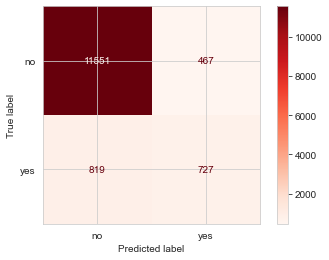

In [91]:
con_mat4 = confusion_matrix(test_y, pred_cat1)
print(con_mat4)
plot_confusion_matrix(cat1, test_x, test_y, cmap = plt.cm.Reds);

In [92]:
print("Accuracy: {}".format(accuracy_score(test_y, pred_cat1)))
print(classification_report(test_y, pred_cat1))

Accuracy: 0.9051902093777646
              precision    recall  f1-score   support

          no       0.93      0.96      0.95     12018
         yes       0.61      0.47      0.53      1546

    accuracy                           0.91     13564
   macro avg       0.77      0.72      0.74     13564
weighted avg       0.90      0.91      0.90     13564



- case 2: learning rate와 depth를 줄인 경우

In [93]:
start = time.time()
cat2 = CatBoostClassifier(
    boosting_type="Plain",
    random_state=777, 
    depth=2,
    learning_rate = 0.01,
    loss_function='Logloss'
)


cat2.fit(train_x, train_y, 
        verbose=True,
        cat_features = catcols 
)

print("실행시간:{}".format(time.time()-start))
pred_cat2 = cat2.predict(test_x)

0:	learn: 0.6833367	total: 31.2ms	remaining: 31.1s
1:	learn: 0.6732268	total: 58.5ms	remaining: 29.2s
2:	learn: 0.6630918	total: 93.1ms	remaining: 30.9s
3:	learn: 0.6544864	total: 127ms	remaining: 31.6s
4:	learn: 0.6453837	total: 152ms	remaining: 30.2s
5:	learn: 0.6361376	total: 182ms	remaining: 30.2s
6:	learn: 0.6275898	total: 208ms	remaining: 29.5s
7:	learn: 0.6196429	total: 237ms	remaining: 29.4s
8:	learn: 0.6117728	total: 272ms	remaining: 29.9s
9:	learn: 0.6044552	total: 304ms	remaining: 30.1s
10:	learn: 0.5968114	total: 330ms	remaining: 29.7s
11:	learn: 0.5898251	total: 358ms	remaining: 29.5s
12:	learn: 0.5818380	total: 390ms	remaining: 29.6s
13:	learn: 0.5746194	total: 419ms	remaining: 29.5s
14:	learn: 0.5673825	total: 456ms	remaining: 29.9s
15:	learn: 0.5604651	total: 478ms	remaining: 29.4s
16:	learn: 0.5538935	total: 508ms	remaining: 29.4s
17:	learn: 0.5479318	total: 538ms	remaining: 29.3s
18:	learn: 0.5420721	total: 564ms	remaining: 29.1s
19:	learn: 0.5356254	total: 598ms	rema

162:	learn: 0.2770613	total: 4.73s	remaining: 24.3s
163:	learn: 0.2763247	total: 4.77s	remaining: 24.3s
164:	learn: 0.2759889	total: 4.79s	remaining: 24.2s
165:	learn: 0.2756592	total: 4.81s	remaining: 24.2s
166:	learn: 0.2753886	total: 4.84s	remaining: 24.1s
167:	learn: 0.2751146	total: 4.86s	remaining: 24.1s
168:	learn: 0.2748203	total: 4.89s	remaining: 24s
169:	learn: 0.2745140	total: 4.91s	remaining: 24s
170:	learn: 0.2741186	total: 4.94s	remaining: 24s
171:	learn: 0.2737242	total: 4.97s	remaining: 23.9s
172:	learn: 0.2730748	total: 4.99s	remaining: 23.9s
173:	learn: 0.2727834	total: 5.03s	remaining: 23.9s
174:	learn: 0.2721303	total: 5.05s	remaining: 23.8s
175:	learn: 0.2719163	total: 5.07s	remaining: 23.7s
176:	learn: 0.2716069	total: 5.1s	remaining: 23.7s
177:	learn: 0.2711465	total: 5.12s	remaining: 23.6s
178:	learn: 0.2707296	total: 5.16s	remaining: 23.6s
179:	learn: 0.2703625	total: 5.18s	remaining: 23.6s
180:	learn: 0.2701697	total: 5.21s	remaining: 23.6s
181:	learn: 0.26995

321:	learn: 0.2450876	total: 9.26s	remaining: 19.5s
322:	learn: 0.2450329	total: 9.29s	remaining: 19.5s
323:	learn: 0.2449574	total: 9.33s	remaining: 19.5s
324:	learn: 0.2449078	total: 9.36s	remaining: 19.4s
325:	learn: 0.2448501	total: 9.4s	remaining: 19.4s
326:	learn: 0.2447336	total: 9.44s	remaining: 19.4s
327:	learn: 0.2446741	total: 9.47s	remaining: 19.4s
328:	learn: 0.2445284	total: 9.5s	remaining: 19.4s
329:	learn: 0.2444386	total: 9.54s	remaining: 19.4s
330:	learn: 0.2443918	total: 9.58s	remaining: 19.4s
331:	learn: 0.2442643	total: 9.6s	remaining: 19.3s
332:	learn: 0.2441696	total: 9.63s	remaining: 19.3s
333:	learn: 0.2441139	total: 9.66s	remaining: 19.3s
334:	learn: 0.2440350	total: 9.68s	remaining: 19.2s
335:	learn: 0.2439810	total: 9.71s	remaining: 19.2s
336:	learn: 0.2438324	total: 9.75s	remaining: 19.2s
337:	learn: 0.2437729	total: 9.78s	remaining: 19.2s
338:	learn: 0.2436957	total: 9.8s	remaining: 19.1s
339:	learn: 0.2436032	total: 9.82s	remaining: 19.1s
340:	learn: 0.24

481:	learn: 0.2346908	total: 14.2s	remaining: 15.2s
482:	learn: 0.2346550	total: 14.2s	remaining: 15.2s
483:	learn: 0.2345684	total: 14.2s	remaining: 15.2s
484:	learn: 0.2345376	total: 14.2s	remaining: 15.1s
485:	learn: 0.2344934	total: 14.3s	remaining: 15.1s
486:	learn: 0.2344565	total: 14.3s	remaining: 15.1s
487:	learn: 0.2343618	total: 14.4s	remaining: 15.1s
488:	learn: 0.2343188	total: 14.4s	remaining: 15s
489:	learn: 0.2342890	total: 14.4s	remaining: 15s
490:	learn: 0.2342644	total: 14.5s	remaining: 15s
491:	learn: 0.2342422	total: 14.5s	remaining: 15s
492:	learn: 0.2342189	total: 14.5s	remaining: 14.9s
493:	learn: 0.2341821	total: 14.5s	remaining: 14.9s
494:	learn: 0.2341038	total: 14.6s	remaining: 14.9s
495:	learn: 0.2340593	total: 14.6s	remaining: 14.9s
496:	learn: 0.2340245	total: 14.6s	remaining: 14.8s
497:	learn: 0.2340023	total: 14.7s	remaining: 14.8s
498:	learn: 0.2339663	total: 14.7s	remaining: 14.8s
499:	learn: 0.2339042	total: 14.7s	remaining: 14.7s
500:	learn: 0.233860

643:	learn: 0.2293626	total: 18.8s	remaining: 10.4s
644:	learn: 0.2293149	total: 18.8s	remaining: 10.4s
645:	learn: 0.2292943	total: 18.8s	remaining: 10.3s
646:	learn: 0.2292697	total: 18.9s	remaining: 10.3s
647:	learn: 0.2292462	total: 18.9s	remaining: 10.3s
648:	learn: 0.2292237	total: 18.9s	remaining: 10.2s
649:	learn: 0.2292004	total: 19s	remaining: 10.2s
650:	learn: 0.2291759	total: 19s	remaining: 10.2s
651:	learn: 0.2291374	total: 19s	remaining: 10.2s
652:	learn: 0.2291164	total: 19.1s	remaining: 10.1s
653:	learn: 0.2290979	total: 19.1s	remaining: 10.1s
654:	learn: 0.2290826	total: 19.1s	remaining: 10.1s
655:	learn: 0.2290607	total: 19.1s	remaining: 10s
656:	learn: 0.2290381	total: 19.2s	remaining: 10s
657:	learn: 0.2290257	total: 19.2s	remaining: 9.98s
658:	learn: 0.2290096	total: 19.2s	remaining: 9.95s
659:	learn: 0.2289883	total: 19.3s	remaining: 9.92s
660:	learn: 0.2289684	total: 19.3s	remaining: 9.89s
661:	learn: 0.2289537	total: 19.3s	remaining: 9.87s
662:	learn: 0.2288913	

806:	learn: 0.2258621	total: 23.4s	remaining: 5.6s
807:	learn: 0.2258487	total: 23.5s	remaining: 5.58s
808:	learn: 0.2258384	total: 23.5s	remaining: 5.56s
809:	learn: 0.2258186	total: 23.6s	remaining: 5.53s
810:	learn: 0.2257993	total: 23.6s	remaining: 5.5s
811:	learn: 0.2257557	total: 23.6s	remaining: 5.47s
812:	learn: 0.2257404	total: 23.7s	remaining: 5.44s
813:	learn: 0.2257260	total: 23.7s	remaining: 5.41s
814:	learn: 0.2257052	total: 23.7s	remaining: 5.38s
815:	learn: 0.2256893	total: 23.7s	remaining: 5.35s
816:	learn: 0.2256685	total: 23.8s	remaining: 5.32s
817:	learn: 0.2256502	total: 23.8s	remaining: 5.29s
818:	learn: 0.2256218	total: 23.8s	remaining: 5.26s
819:	learn: 0.2256066	total: 23.8s	remaining: 5.23s
820:	learn: 0.2255894	total: 23.9s	remaining: 5.21s
821:	learn: 0.2255783	total: 23.9s	remaining: 5.18s
822:	learn: 0.2255604	total: 23.9s	remaining: 5.15s
823:	learn: 0.2255423	total: 24s	remaining: 5.12s
824:	learn: 0.2255314	total: 24s	remaining: 5.09s
825:	learn: 0.2255

967:	learn: 0.2231704	total: 28.1s	remaining: 930ms
968:	learn: 0.2231372	total: 28.2s	remaining: 901ms
969:	learn: 0.2231258	total: 28.2s	remaining: 872ms
970:	learn: 0.2231134	total: 28.2s	remaining: 843ms
971:	learn: 0.2231024	total: 28.2s	remaining: 814ms
972:	learn: 0.2230904	total: 28.3s	remaining: 784ms
973:	learn: 0.2230841	total: 28.3s	remaining: 755ms
974:	learn: 0.2230760	total: 28.3s	remaining: 726ms
975:	learn: 0.2230654	total: 28.3s	remaining: 697ms
976:	learn: 0.2230575	total: 28.4s	remaining: 668ms
977:	learn: 0.2230485	total: 28.4s	remaining: 639ms
978:	learn: 0.2230369	total: 28.4s	remaining: 610ms
979:	learn: 0.2230295	total: 28.5s	remaining: 581ms
980:	learn: 0.2230198	total: 28.5s	remaining: 552ms
981:	learn: 0.2230109	total: 28.5s	remaining: 523ms
982:	learn: 0.2230021	total: 28.6s	remaining: 494ms
983:	learn: 0.2229858	total: 28.6s	remaining: 465ms
984:	learn: 0.2229703	total: 28.6s	remaining: 436ms
985:	learn: 0.2229599	total: 28.7s	remaining: 407ms
986:	learn: 

[[11694   324]
 [  984   562]]


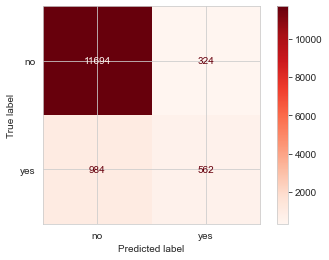

In [94]:
con_mat5 = confusion_matrix(test_y, pred_cat2)
print(con_mat5)
plot_confusion_matrix(cat2, test_x, test_y, cmap = plt.cm.Reds);

In [95]:
print("Accuracy: {}".format(accuracy_score(test_y, pred_cat2)))
print(classification_report(test_y, pred_cat2))

Accuracy: 0.9035682689472132
              precision    recall  f1-score   support

          no       0.92      0.97      0.95     12018
         yes       0.63      0.36      0.46      1546

    accuracy                           0.90     13564
   macro avg       0.78      0.67      0.70     13564
weighted avg       0.89      0.90      0.89     13564



- case 3: Hyperparamter tuning

In [98]:
start = time.time()
cat3 = CatBoostClassifier(
    boosting_type="Plain",
    random_state=777,
    loss_function='Logloss',
    cat_features=catcols,
    verbose=500
)
cat_grid = {'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4,6],
        'l2_leaf_reg': [0.1, 1, 3],
        'iterations':[500, 1000],
        'border_count':[64,254],
        'rsm':[0.85, 1]
        }


grid_search_result = cat3.grid_search(cat_grid,X=train_x,y=train_y,plot=True)
print(grid_search_result)

print("실행시간:{}".format(time.time()-start))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6816901	test: 0.6816862	best: 0.6816862 (0)	total: 44ms	remaining: 22s
499:	learn: 0.2152628	test: 0.2113820	best: 0.2113820 (499)	total: 21.9s	remaining: 0us

bestTest = 0.2113820175
bestIteration = 499

0:	loss: 0.2113820	best: 0.2113820 (0)	total: 21.9s	remaining: 52m 18s
0:	learn: 0.6379468	test: 0.6378810	best: 0.6378810 (0)	total: 47.7ms	remaining: 23.8s
499:	learn: 0.1932755	test: 0.2001228	best: 0.2001228 (499)	total: 23.4s	remaining: 0us

bestTest = 0.2001228349
bestIteration = 499

1:	loss: 0.2001228	best: 0.2001228 (1)	total: 45.4s	remaining: 53m 42s
0:	learn: 0.5879205	test: 0.5876740	best: 0.5876740 (0)	total: 47.3ms	remaining: 23.6s
499:	learn: 0.1805239	test: 0.2014647	best: 0.2006339 (352)	total: 22.8s	remaining: 0us

bestTest = 0.2006339206
bestIteration = 352

2:	loss: 0.2006339	best: 0.2001228 (1)	total: 1m 8s	remaining: 53m 25s
0:	learn: 0.6816901	test: 0.6816862	best: 0.6816862 (0)	total: 43.4ms	remaining: 21.7s
499:	learn: 0.2153656	test: 0.2111056	bes

499:	learn: 0.1781308	test: 0.1973555	best: 0.1973555 (499)	total: 27s	remaining: 0us

bestTest = 0.1973555083
bestIteration = 499

25:	loss: 0.1973555	best: 0.1973555 (25)	total: 12m 30s	remaining: 56m 44s
0:	learn: 0.5796644	test: 0.5804846	best: 0.5804846 (0)	total: 54ms	remaining: 26.9s
499:	learn: 0.1542192	test: 0.1994587	best: 0.1978771 (250)	total: 27.9s	remaining: 0us

bestTest = 0.1978771044
bestIteration = 250

26:	loss: 0.1978771	best: 0.1973555 (25)	total: 12m 58s	remaining: 56m 11s
0:	learn: 0.6806941	test: 0.6808016	best: 0.6808016 (0)	total: 47.1ms	remaining: 47s
500:	learn: 0.2022140	test: 0.2045826	best: 0.2045826 (500)	total: 27.5s	remaining: 27.4s
999:	learn: 0.1906803	test: 0.2002159	best: 0.2002159 (999)	total: 55.1s	remaining: 0us

bestTest = 0.2002159251
bestIteration = 999

27:	loss: 0.2002159	best: 0.1973555 (25)	total: 13m 53s	remaining: 57m 31s
0:	learn: 0.6333326	test: 0.6338075	best: 0.6338075 (0)	total: 64.3ms	remaining: 1m 4s
500:	learn: 0.1660316	test: 

500:	learn: 0.1956836	test: 0.2006129	best: 0.2005935 (498)	total: 19.7s	remaining: 19.6s
999:	learn: 0.1832848	test: 0.1990604	best: 0.1989918 (963)	total: 39.8s	remaining: 0us

bestTest = 0.1989918187
bestIteration = 963

49:	loss: 0.1989918	best: 0.1969189 (34)	total: 27m 41s	remaining: 52m 3s
0:	learn: 0.5888175	test: 0.5889954	best: 0.5889954 (0)	total: 36.5ms	remaining: 36.4s
500:	learn: 0.1832786	test: 0.2003736	best: 0.1996789 (390)	total: 20.3s	remaining: 20.2s
999:	learn: 0.1666459	test: 0.2019537	best: 0.1996789 (390)	total: 41.3s	remaining: 0us

bestTest = 0.1996789253
bestIteration = 390

50:	loss: 0.1996789	best: 0.1969189 (34)	total: 28m 22s	remaining: 51m 44s
0:	learn: 0.6818042	test: 0.6818370	best: 0.6818370 (0)	total: 39ms	remaining: 39s
500:	learn: 0.2157002	test: 0.2114839	best: 0.2114839 (500)	total: 19.6s	remaining: 19.5s
999:	learn: 0.2070547	test: 0.2054294	best: 0.2054294 (999)	total: 39.5s	remaining: 0us

bestTest = 0.2054294282
bestIteration = 999

51:	loss:

499:	learn: 0.1933484	test: 0.2016807	best: 0.2016561 (498)	total: 20.5s	remaining: 0us

bestTest = 0.2016561091
bestIteration = 498

73:	loss: 0.2016561	best: 0.1969189 (34)	total: 43m 54s	remaining: 41m 32s
0:	learn: 0.5807455	test: 0.5810244	best: 0.5810244 (0)	total: 55.1ms	remaining: 27.5s
499:	learn: 0.1795036	test: 0.2011246	best: 0.2005970 (411)	total: 20s	remaining: 0us

bestTest = 0.2005969535
bestIteration = 411

74:	loss: 0.2005970	best: 0.1969189 (34)	total: 44m 14s	remaining: 40m 42s
0:	learn: 0.6808312	test: 0.6808746	best: 0.6808746 (0)	total: 44.6ms	remaining: 22.3s
499:	learn: 0.2157162	test: 0.2114905	best: 0.2114905 (499)	total: 19.7s	remaining: 0us

bestTest = 0.2114904779
bestIteration = 499

75:	loss: 0.2114905	best: 0.1969189 (34)	total: 44m 34s	remaining: 39m 52s
0:	learn: 0.6339699	test: 0.6341520	best: 0.6341520 (0)	total: 59ms	remaining: 29.4s
499:	learn: 0.1952795	test: 0.2014425	best: 0.2014241 (495)	total: 18.8s	remaining: 0us

bestTest = 0.2014240677
bes

500:	learn: 0.2027577	test: 0.2046190	best: 0.2046190 (500)	total: 29.4s	remaining: 29.3s
999:	learn: 0.1908234	test: 0.2004455	best: 0.2004455 (999)	total: 59.3s	remaining: 0us

bestTest = 0.2004455209
bestIteration = 999

99:	loss: 0.2004455	best: 0.1969189 (34)	total: 58m 7s	remaining: 25m 34s
0:	learn: 0.6338932	test: 0.6340603	best: 0.6340603 (0)	total: 54.8ms	remaining: 54.8s
500:	learn: 0.1675125	test: 0.1991471	best: 0.1987872 (440)	total: 30.7s	remaining: 30.6s
999:	learn: 0.1392769	test: 0.2030874	best: 0.1987872 (440)	total: 1m 2s	remaining: 0us

bestTest = 0.1987872432
bestIteration = 440

100:	loss: 0.1987872	best: 0.1969189 (34)	total: 59m 9s	remaining: 25m 11s
0:	learn: 0.5806131	test: 0.5808698	best: 0.5808698 (0)	total: 73.3ms	remaining: 1m 13s
500:	learn: 0.1379695	test: 0.2024196	best: 0.1992356 (142)	total: 30.4s	remaining: 30.2s
999:	learn: 0.1014354	test: 0.2121087	best: 0.1992356 (142)	total: 1m	remaining: 0us

bestTest = 0.1992355503
bestIteration = 142

101:	lo

500:	learn: 0.2156767	test: 0.2115596	best: 0.2115596 (500)	total: 20.2s	remaining: 20.1s
999:	learn: 0.2070334	test: 0.2054181	best: 0.2054181 (999)	total: 40.8s	remaining: 0us

bestTest = 0.2054181101
bestIteration = 999

123:	loss: 0.2054181	best: 0.1969189 (34)	total: 1h 14m 50s	remaining: 12m 4s
0:	learn: 0.6377861	test: 0.6377879	best: 0.6377879 (0)	total: 36.1ms	remaining: 36.1s
500:	learn: 0.1959885	test: 0.2010457	best: 0.2010457 (500)	total: 20.4s	remaining: 20.3s
999:	learn: 0.1850628	test: 0.2003330	best: 0.2000716 (894)	total: 41.5s	remaining: 0us

bestTest = 0.2000716092
bestIteration = 894

124:	loss: 0.2000716	best: 0.1969189 (34)	total: 1h 15m 31s	remaining: 11m 28s
0:	learn: 0.5876644	test: 0.5875757	best: 0.5875757 (0)	total: 42.6ms	remaining: 42.6s
500:	learn: 0.1853103	test: 0.1993406	best: 0.1992396 (485)	total: 20.9s	remaining: 20.8s
999:	learn: 0.1692303	test: 0.2003464	best: 0.1992396 (485)	total: 42.4s	remaining: 0us

bestTest = 0.199239582
bestIteration = 485

{'params': {'border_count': 64, 'depth': 6, 'l2_leaf_reg': 3, 'iterations': 1000, 'rsm': 0.85, 'learning_rate': 0.05}, 'cv_results': defaultdict(<class 'list'>, {'iterations': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186

In [99]:
grid_search_result

{'params': {'border_count': 64,
  'depth': 6,
  'l2_leaf_reg': 3,
  'iterations': 1000,
  'rsm': 0.85,
  'learning_rate': 0.05},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43

In [100]:
start = time.time()
cat3 = CatBoostClassifier(
    boosting_type="Plain",
    border_count=64,
    rsm=0.85,
    depth=6,
    l2_leaf_reg=3,
    iterations=1000,
    learning_rate=0.05,
    random_state=777, 
    loss_function='Logloss'
)


cat3.fit(train_x, train_y,
        verbose=True,
        cat_features = catcols 
)

print("실행시간:{}".format(time.time()-start))
pred_cat3 = cat3.predict(test_x)

0:	learn: 0.6312020	total: 56.9ms	remaining: 56.9s
1:	learn: 0.5801487	total: 110ms	remaining: 55.1s
2:	learn: 0.5362816	total: 169ms	remaining: 56s
3:	learn: 0.5022858	total: 214ms	remaining: 53.4s
4:	learn: 0.4684576	total: 263ms	remaining: 52.3s
5:	learn: 0.4436094	total: 325ms	remaining: 53.9s
6:	learn: 0.4244585	total: 368ms	remaining: 52.2s
7:	learn: 0.4015101	total: 425ms	remaining: 52.7s
8:	learn: 0.3778811	total: 495ms	remaining: 54.5s
9:	learn: 0.3585681	total: 559ms	remaining: 55.4s
10:	learn: 0.3443907	total: 616ms	remaining: 55.3s
11:	learn: 0.3329974	total: 667ms	remaining: 54.9s
12:	learn: 0.3210051	total: 738ms	remaining: 56s
13:	learn: 0.3103794	total: 815ms	remaining: 57.4s
14:	learn: 0.3052910	total: 845ms	remaining: 55.5s
15:	learn: 0.2976533	total: 890ms	remaining: 54.7s
16:	learn: 0.2899572	total: 939ms	remaining: 54.3s
17:	learn: 0.2825306	total: 994ms	remaining: 54.2s
18:	learn: 0.2764843	total: 1.07s	remaining: 55.1s
19:	learn: 0.2718883	total: 1.14s	remaining:

162:	learn: 0.1987615	total: 9.8s	remaining: 50.3s
163:	learn: 0.1986828	total: 9.86s	remaining: 50.3s
164:	learn: 0.1985619	total: 9.93s	remaining: 50.2s
165:	learn: 0.1984926	total: 9.99s	remaining: 50.2s
166:	learn: 0.1984077	total: 10.1s	remaining: 50.2s
167:	learn: 0.1983567	total: 10.1s	remaining: 50.1s
168:	learn: 0.1983125	total: 10.2s	remaining: 50s
169:	learn: 0.1982855	total: 10.2s	remaining: 49.9s
170:	learn: 0.1982212	total: 10.3s	remaining: 49.8s
171:	learn: 0.1982212	total: 10.3s	remaining: 49.6s
172:	learn: 0.1981460	total: 10.4s	remaining: 49.6s
173:	learn: 0.1980458	total: 10.4s	remaining: 49.5s
174:	learn: 0.1979118	total: 10.5s	remaining: 49.5s
175:	learn: 0.1978722	total: 10.6s	remaining: 49.4s
176:	learn: 0.1977948	total: 10.6s	remaining: 49.4s
177:	learn: 0.1977346	total: 10.7s	remaining: 49.5s
178:	learn: 0.1977087	total: 10.8s	remaining: 49.5s
179:	learn: 0.1976662	total: 10.8s	remaining: 49.4s
180:	learn: 0.1976106	total: 10.9s	remaining: 49.5s
181:	learn: 0.1

323:	learn: 0.1878758	total: 20.7s	remaining: 43.2s
324:	learn: 0.1878666	total: 20.8s	remaining: 43.2s
325:	learn: 0.1877683	total: 20.9s	remaining: 43.2s
326:	learn: 0.1877376	total: 21s	remaining: 43.2s
327:	learn: 0.1877220	total: 21.1s	remaining: 43.2s
328:	learn: 0.1876900	total: 21.2s	remaining: 43.2s
329:	learn: 0.1876124	total: 21.3s	remaining: 43.2s
330:	learn: 0.1875564	total: 21.4s	remaining: 43.3s
331:	learn: 0.1875390	total: 21.5s	remaining: 43.3s
332:	learn: 0.1874347	total: 21.6s	remaining: 43.3s
333:	learn: 0.1874145	total: 21.7s	remaining: 43.3s
334:	learn: 0.1873431	total: 21.8s	remaining: 43.2s
335:	learn: 0.1873152	total: 21.8s	remaining: 43.1s
336:	learn: 0.1872552	total: 21.9s	remaining: 43s
337:	learn: 0.1872099	total: 21.9s	remaining: 43s
338:	learn: 0.1871546	total: 22s	remaining: 42.9s
339:	learn: 0.1870740	total: 22.1s	remaining: 42.8s
340:	learn: 0.1870278	total: 22.1s	remaining: 42.8s
341:	learn: 0.1869159	total: 22.2s	remaining: 42.7s
342:	learn: 0.186865

482:	learn: 0.1814912	total: 31.6s	remaining: 33.8s
483:	learn: 0.1814423	total: 31.6s	remaining: 33.7s
484:	learn: 0.1813797	total: 31.7s	remaining: 33.6s
485:	learn: 0.1813691	total: 31.7s	remaining: 33.6s
486:	learn: 0.1813286	total: 31.8s	remaining: 33.5s
487:	learn: 0.1812499	total: 31.9s	remaining: 33.4s
488:	learn: 0.1812090	total: 31.9s	remaining: 33.4s
489:	learn: 0.1812002	total: 32s	remaining: 33.3s
490:	learn: 0.1811831	total: 32.1s	remaining: 33.2s
491:	learn: 0.1811350	total: 32.1s	remaining: 33.2s
492:	learn: 0.1810950	total: 32.2s	remaining: 33.1s
493:	learn: 0.1810182	total: 32.2s	remaining: 33s
494:	learn: 0.1809669	total: 32.3s	remaining: 33s
495:	learn: 0.1808840	total: 32.4s	remaining: 32.9s
496:	learn: 0.1808301	total: 32.4s	remaining: 32.8s
497:	learn: 0.1807110	total: 32.5s	remaining: 32.7s
498:	learn: 0.1806805	total: 32.5s	remaining: 32.7s
499:	learn: 0.1806722	total: 32.6s	remaining: 32.6s
500:	learn: 0.1806285	total: 32.7s	remaining: 32.5s
501:	learn: 0.1805

641:	learn: 0.1751452	total: 41s	remaining: 22.9s
642:	learn: 0.1751199	total: 41.1s	remaining: 22.8s
643:	learn: 0.1750515	total: 41.1s	remaining: 22.7s
644:	learn: 0.1749713	total: 41.2s	remaining: 22.7s
645:	learn: 0.1749484	total: 41.2s	remaining: 22.6s
646:	learn: 0.1749248	total: 41.3s	remaining: 22.5s
647:	learn: 0.1748797	total: 41.3s	remaining: 22.4s
648:	learn: 0.1748507	total: 41.4s	remaining: 22.4s
649:	learn: 0.1748111	total: 41.5s	remaining: 22.3s
650:	learn: 0.1747596	total: 41.5s	remaining: 22.3s
651:	learn: 0.1746840	total: 41.6s	remaining: 22.2s
652:	learn: 0.1746469	total: 41.7s	remaining: 22.2s
653:	learn: 0.1745948	total: 41.8s	remaining: 22.1s
654:	learn: 0.1745442	total: 41.8s	remaining: 22s
655:	learn: 0.1745201	total: 41.9s	remaining: 22s
656:	learn: 0.1744918	total: 42s	remaining: 21.9s
657:	learn: 0.1744458	total: 42.1s	remaining: 21.9s
658:	learn: 0.1744123	total: 42.2s	remaining: 21.8s
659:	learn: 0.1743948	total: 42.2s	remaining: 21.7s
660:	learn: 0.174386

800:	learn: 0.1692447	total: 50s	remaining: 12.4s
801:	learn: 0.1692363	total: 50s	remaining: 12.3s
802:	learn: 0.1691690	total: 50.1s	remaining: 12.3s
803:	learn: 0.1691509	total: 50.1s	remaining: 12.2s
804:	learn: 0.1691082	total: 50.2s	remaining: 12.2s
805:	learn: 0.1690892	total: 50.2s	remaining: 12.1s
806:	learn: 0.1690497	total: 50.3s	remaining: 12s
807:	learn: 0.1689856	total: 50.3s	remaining: 12s
808:	learn: 0.1689462	total: 50.4s	remaining: 11.9s
809:	learn: 0.1688960	total: 50.4s	remaining: 11.8s
810:	learn: 0.1688496	total: 50.5s	remaining: 11.8s
811:	learn: 0.1688463	total: 50.5s	remaining: 11.7s
812:	learn: 0.1688228	total: 50.6s	remaining: 11.6s
813:	learn: 0.1687801	total: 50.6s	remaining: 11.6s
814:	learn: 0.1687430	total: 50.7s	remaining: 11.5s
815:	learn: 0.1687033	total: 50.8s	remaining: 11.5s
816:	learn: 0.1686462	total: 50.8s	remaining: 11.4s
817:	learn: 0.1685966	total: 50.9s	remaining: 11.3s
818:	learn: 0.1685700	total: 50.9s	remaining: 11.3s
819:	learn: 0.168533

959:	learn: 0.1632890	total: 58.9s	remaining: 2.45s
960:	learn: 0.1632680	total: 59s	remaining: 2.39s
961:	learn: 0.1632412	total: 59s	remaining: 2.33s
962:	learn: 0.1632260	total: 59.1s	remaining: 2.27s
963:	learn: 0.1632200	total: 59.1s	remaining: 2.21s
964:	learn: 0.1631631	total: 59.2s	remaining: 2.15s
965:	learn: 0.1631550	total: 59.2s	remaining: 2.08s
966:	learn: 0.1631498	total: 59.3s	remaining: 2.02s
967:	learn: 0.1631192	total: 59.3s	remaining: 1.96s
968:	learn: 0.1630797	total: 59.4s	remaining: 1.9s
969:	learn: 0.1630543	total: 59.4s	remaining: 1.84s
970:	learn: 0.1630181	total: 59.5s	remaining: 1.78s
971:	learn: 0.1630085	total: 59.5s	remaining: 1.72s
972:	learn: 0.1630062	total: 59.6s	remaining: 1.65s
973:	learn: 0.1629850	total: 59.6s	remaining: 1.59s
974:	learn: 0.1629717	total: 59.7s	remaining: 1.53s
975:	learn: 0.1629202	total: 59.8s	remaining: 1.47s
976:	learn: 0.1628801	total: 59.8s	remaining: 1.41s
977:	learn: 0.1628082	total: 59.9s	remaining: 1.35s
978:	learn: 0.162

[[11562   456]
 [  817   729]]


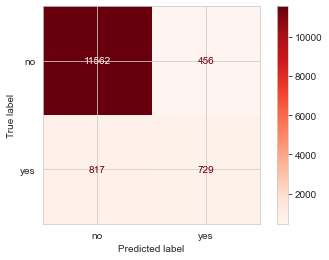

In [101]:
con_mat6 = confusion_matrix(test_y, pred_cat3)
print(con_mat6)
plot_confusion_matrix(cat3, test_x, test_y, cmap = plt.cm.Reds);

In [102]:
print("Accuracy: {}".format(accuracy_score(test_y, pred_cat3)))
print(classification_report(test_y, pred_cat3))

Accuracy: 0.9061486287230905
              precision    recall  f1-score   support

          no       0.93      0.96      0.95     12018
         yes       0.62      0.47      0.53      1546

    accuracy                           0.91     13564
   macro avg       0.77      0.72      0.74     13564
weighted avg       0.90      0.91      0.90     13564



#### 3) LightGBM

In [103]:
train_x, test_x, train_y, test_y = train_test_split(X1, y, test_size=0.3, random_state=777)
train_x.head()

,age,balance,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
41161,22,4111,65,1,-1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3123,38,360,220,2,-1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
17925,54,0,250,5,-1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
40638,30,685,299,2,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6676,53,45,171,6,-1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


- case 1: 기본 파라미터 사용

In [104]:
lgbm1 = LGBMClassifier(random_state=777)

start = time.time()
lgbm1.fit(train_x, train_y, eval_metric="logloss")
print("실행시간:{}".format(time.time()-start))
pred_lgbm1 = lgbm1.predict(test_x)

실행시간:0.21889853477478027


[[11570   448]
 [  824   722]]


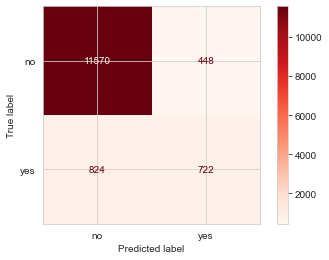

In [105]:
con_mat7 = confusion_matrix(test_y, pred_lgbm1)
print(con_mat7)
plot_confusion_matrix(lgbm1, test_x, test_y, cmap = plt.cm.Reds);

In [106]:
print("Accuracy: {}".format(accuracy_score(test_y, pred_lgbm1)))
print(classification_report(test_y, pred_lgbm1))

Accuracy: 0.9062223532881156
              precision    recall  f1-score   support

          no       0.93      0.96      0.95     12018
         yes       0.62      0.47      0.53      1546

    accuracy                           0.91     13564
   macro avg       0.78      0.71      0.74     13564
weighted avg       0.90      0.91      0.90     13564



- case 2: learning rate를 작게, 트리 생성 횟수는 크게 설정

In [108]:
lgbm2 = LGBMClassifier(random_state=777,
                      learning_rate=0.01,
                      n_estimators=1000)

start = time.time()
lgbm2.fit(train_x, train_y, eval_metric="logloss")
print("실행시간:{}".format(time.time()-start))
pred_lgbm2 = lgbm2.predict(test_x)

실행시간:1.7060112953186035


[[11565   453]
 [  809   737]]


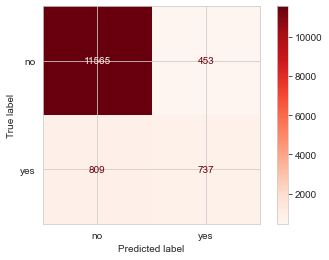

In [109]:
con_mat8 = confusion_matrix(test_y, pred_lgbm2)
print(con_mat8)
plot_confusion_matrix(lgbm2, test_x, test_y, cmap = plt.cm.Reds);

In [110]:
print("Accuracy: {}".format(accuracy_score(test_y, pred_lgbm2)))
print(classification_report(test_y, pred_lgbm2))

Accuracy: 0.9069595989383663
              precision    recall  f1-score   support

          no       0.93      0.96      0.95     12018
         yes       0.62      0.48      0.54      1546

    accuracy                           0.91     13564
   macro avg       0.78      0.72      0.74     13564
weighted avg       0.90      0.91      0.90     13564



- case 3: Hyperparmater tuning

In [115]:
start = time.time()
lgbm3 = LGBMClassifier(random_state=777)
lgbm_grid = {
    'num_leaves':[10,20],
    'max_depth':[-1,4, 6],
    "min_data":[500, 750, 1000],
    'max_bin':[255,512],
    'learning_rate':[0.01, 0.05, 0.1],
    'n_estimators':[500, 1000]

}
lgbmCV = GridSearchCV(lgbm3, lgbm_grid, verbose=-1, cv=3)
lgbmCV.fit(train_x, train_y)
print("실행시간:{}".format(time.time()-start))

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_l

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_l

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: 

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_l

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_i

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_l

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: 

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_l

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=1000. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=500. Current value: min

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_leaf=750
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=750. Current value: min_data_in_l

In [116]:
lgbmCV.best_params_

{'learning_rate': 0.01,
 'max_bin': 255,
 'max_depth': -1,
 'min_data': 500,
 'n_estimators': 1000,
 'num_leaves': 20}

In [117]:
lgbm3 = LGBMClassifier(random_state=777,
                       num_leaves=20,
                       min_data=500,
                       max_depth=-1,
                       max_bin=255,
                      learning_rate=0.01,
                      n_estimators=1000)

start = time.time()
lgbm3.fit(train_x, train_y, eval_metric="logloss")
print("실행시간:{}".format(time.time()-start))
pred_lgbm3 = lgbm3.predict(test_x)

실행시간:1.7119231224060059


[[11570   448]
 [  852   694]]


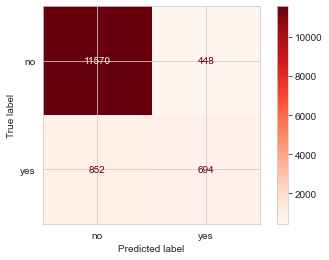

In [118]:
con_mat9 = confusion_matrix(test_y, pred_lgbm3)
print(con_mat9)
plot_confusion_matrix(lgbm3, test_x, test_y, cmap = plt.cm.Reds);

In [119]:
print("Accuracy: {}".format(accuracy_score(test_y, pred_lgbm3)))
print(classification_report(test_y, pred_lgbm3))

Accuracy: 0.9041580654674137
              precision    recall  f1-score   support

          no       0.93      0.96      0.95     12018
         yes       0.61      0.45      0.52      1546

    accuracy                           0.90     13564
   macro avg       0.77      0.71      0.73     13564
weighted avg       0.89      0.90      0.90     13564



#### Best model interpretation
적합한 모델 중 기본 파라미터를 사용한 LightGBM의 case 2가 가장 좋은 성능을 보였다.      
Optimal 모델의 feature importance 및 pdp plot을 확인해본다.

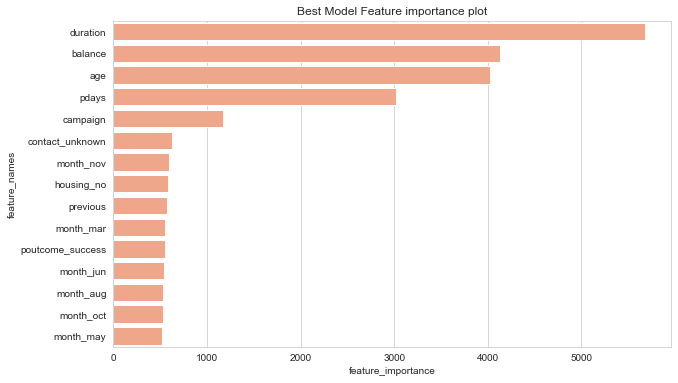

In [123]:
## Feature importance plot
temp = pd.DataFrame({'feature_importance': lgbm2.feature_importances_, 
              'feature_names': train_x.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False).iloc[:15]

fig = plt.figure(figsize=(10, 6))
sns.barplot(x='feature_importance', y='feature_names', data=temp, color="lightsalmon")
plt.title("Best Model Feature importance plot");

In [125]:
bank[['duration', 'balance', 'age']].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0


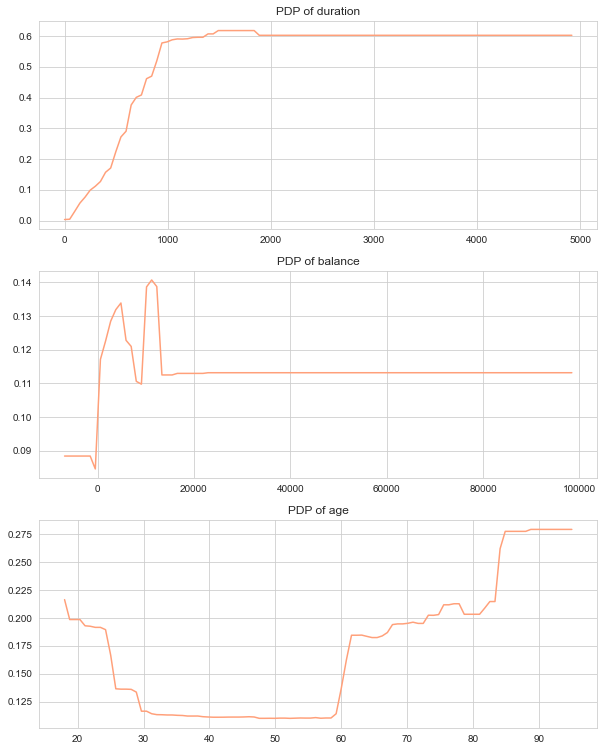

In [127]:
## PDP plot
pdpcols = ['duration', 'balance', 'age']
plt.figure(figsize=(10, 13))
for n in range(len(pdpcols)):
    # 설명변수가 모두 수치형
    tmp = train_x.copy()
    idx = np.linspace(min(tmp.loc[:, pdpcols[n]]), max(tmp.loc[:, pdpcols[n]]), 100)
    results = []
    for i in idx:
        tmp.loc[:, pdpcols[n]] = i
        result = lgbm2.predict_proba(np.array(tmp))
        yes = [r[1] for r in result]
        results.append(np.mean(yes))
    plt.subplot(3, 1, n+1)
    sns.lineplot(x=idx, y=results, color="lightsalmon")
    plt.title("PDP of "+pdpcols[n]);
    
    # 설명변수가 범주형일 경우
#     tmp = train_x.copy()
#     idx = list(bank[pdpcols[n]].unique())
#     results = []
        
#     for i in idx:
#         tmp.loc[:, pdpcols[n]] = i
#         result = cat1.predict_proba(np.array(tmp))
#         yes = [r[1] for r in result]
#         results.append(np.mean(yes))
#     plt.subplot(3, 1, n+1)
#     sns.barplot(x=idx, y=results, color="lightsalmon")
#     plt.title("PDP of "+pdpcols[n]);
